In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
#for ipynb
%matplotlib inline

In [2]:
metadata_path = '../../metadata/MBC/merged_tables_revisions1/merged_key_metadata.txt'
in_dirs = ['../TFBS_nucleosome_profiling_1/results/']
correction = 'uncorrected'
filtering = 'exclusion_filtered'

In [3]:
#get list of files with data

in_files = []
for in_dir in in_dirs:
    for file in os.listdir(in_dir):
        if not file == 'plots':
            in_files.append(in_dir+'/'+file+'/'+file+'.'+correction+'.coverage.tsv')
print(len(in_files))    

254


In [4]:
#get columns with coverage data
plot_columns = np.arange(-990,990,15)
str_plot_columns = [str(m) for m in plot_columns]

In [5]:
#import data
start_time = time.time()
data = pd.DataFrame()
for i,file in enumerate(in_files):
    if i%50==0:
        print(i,'importing',file,time.time()-start_time)
    current = pd.read_csv(file,sep='\t')
    data = data.append(current, ignore_index=True)
        

0 importing ../TFBS_nucleosome_profiling_1/results//MBC_1421_3_ULP/MBC_1421_3_ULP.uncorrected.coverage.tsv 0.0006229877471923828
50 importing ../TFBS_nucleosome_profiling_1/results//MBC_1167_5_ULP/MBC_1167_5_ULP.uncorrected.coverage.tsv 2.0754220485687256
100 importing ../TFBS_nucleosome_profiling_1/results//MBC_1297_ULP/MBC_1297_ULP.uncorrected.coverage.tsv 5.434222221374512
150 importing ../TFBS_nucleosome_profiling_1/results//MBC_1421_5_ULP/MBC_1421_5_ULP.uncorrected.coverage.tsv 10.213010311126709
200 importing ../TFBS_nucleosome_profiling_1/results//MBC_1117_1_ULP/MBC_1117_1_ULP.uncorrected.coverage.tsv 16.369860887527466
250 importing ../TFBS_nucleosome_profiling_1/results//MBC_1111_1_ULP/MBC_1111_1_ULP.uncorrected.coverage.tsv 23.937838315963745


In [6]:
#get the subtype data
subtype_data = pd.read_csv(metadata_path, sep='\t')
metadata_columns = ['sample','patient_id','revisions_ER_status_binary','ulp_wgs_coverage','tumor_fraction','first_passing_sample']
subtype_data = subtype_data[metadata_columns]

#merge with data
print(len(data))
data = data.merge(subtype_data, on = 'sample')
print(len(data['sample'].unique()))


433070
254


In [7]:
data['number_of_sites'].unique()

array([20000, 10000,  5000,  1000])

In [8]:
print(len(data['site_name'].unique()))
data['site_name'].unique()[0:10]

1705


array(['AHR.hg38.20000', 'AR.hg38.20000', 'ARNT.hg38.20000',
       'ARNTL.hg38.20000', 'ASCL1.hg38.20000', 'ASCL2.hg38.20000',
       'ATF1.hg38.20000', 'ATF2.hg38.20000', 'ATF3.hg38.20000',
       'ATF4.hg38.20000'], dtype=object)

In [9]:
#get the key columns
data = data[metadata_columns+['site_name','correction',
                              'central_coverage','amplitude','mean_coverage']+str_plot_columns]
print(len(data))

data['site_group'] = data['site_name'].str.rsplit('.',1,expand = True)[1]+'-sites'


#export only 10000 sites
group = '10000-sites'
df = data[data['site_group']==group]

print(group,len(df['site_name'].unique()))

df.to_csv('merged_data/'+group+'_data_with_features.'+correction+'.'+filtering+'.txt', sep='\t', index=False)

#reformat for logistic regression
reformatted = df[metadata_columns+['site_name','site_group','central_coverage','amplitude','mean_coverage']]
reformatted = reformatted.set_index(metadata_columns+['site_group','site_name']).unstack()
new_column_names = []
for item in reformatted.columns.values:
    new_column_names.append('_'.join(item))
reformatted.columns = new_column_names

reformatted.to_csv('merged_data/'+group+'_reformatted.'+correction+'.'+filtering+'.txt', sep='\t')

print(reformatted.shape)


433070
10000-sites 377
(254, 1131)


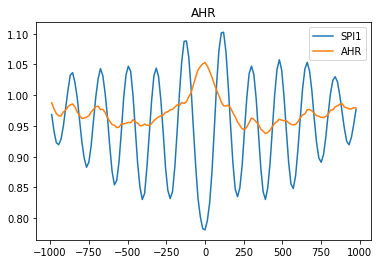

In [10]:
#plot
for site_name in ['SPI1','AHR']:
    current = data[data['site_name'].str.contains(site_name)][str_plot_columns].mean()
    plt.plot(plot_columns,current, label=site_name)
    plt.title(site_name)
    #plt.show()
plt.legend()



fft real -0.2303836271992417
fft imag 0.11360896638350343
fft magn 0.256872756290361
sum x coords -0.23038362719925465
sum y coords 0.11360896638348111
magnitude: 0.25687275629036277


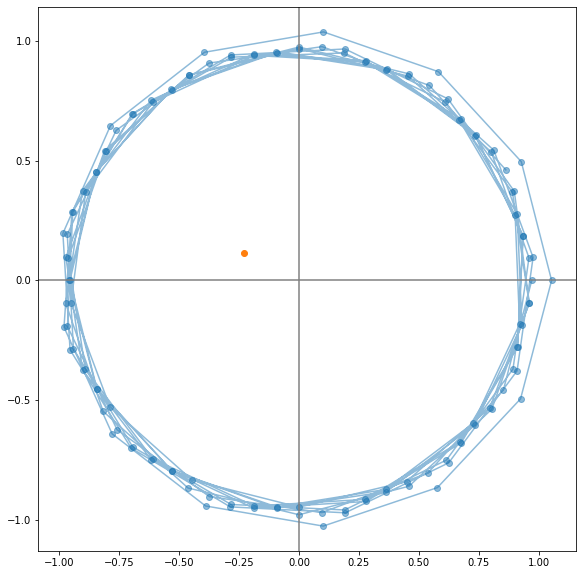

In [11]:
fft_columns = np.arange(-960,960,15)
str_fft_columns = [str(m) for m in fft_columns]

#plot out what the fft is doing for a given frequency
demo_res = np.fft.fft(current[str_fft_columns])
demo_signal = current[str_fft_columns]

frequency = 10
print('fft real', demo_res[frequency].real)
print('fft imag', demo_res[frequency].imag)
print('fft magn',np.abs(demo_res[frequency]))

#get angles for rotation
angles = np.linspace(0,2*np.pi,len(demo_signal)+1)
angles = -angles[0:-1]

#wrapped at frequency
heights = np.sin(angles*frequency)*demo_signal
widths = np.cos(angles*frequency)*demo_signal
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(widths,heights, alpha = 0.5)
ax.scatter(widths,heights, alpha = 0.5)
ax.set_aspect('equal')
ax.scatter(sum(widths),sum(heights))
ax.axvline(0, color = 'grey')
ax.axhline(0, color = 'grey')
print('sum x coords',sum(widths))
print('sum y coords',sum(heights))
print('magnitude:',np.sqrt(sum(widths)**2+sum(heights)**2))

In [12]:
# from scipy.signal import find_peaks
# plt.plot(fft_columns,current)
# peaks =  [fft_columns[m] for m in find_peaks(current)[0]]
# plt.scatter(peaks,[.99 for m in peaks])
# print(peaks)

# spacing = []
# for i in range(len(peaks)-1):
#     spacing.append(peaks[i+1]-peaks[i])
# np.mean(spacing)